# Comparison
    
On the internet there are plenty of articles on how to predict a stocks price using LSTMs. I'll perform an example of that here to compare against later

In [125]:
import pandas as pd
import numpy as np
import math
import random
from datetime import date, timedelta

from sklearn.preprocessing import StandardScaler as SS
from sklearn.metrics import mean_squared_error as MSE

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Nadam

import matplotlib.pyplot as plt
%matplotlib inline

np.seed = 42

In [2]:
df = pd.read_csv('change.csv', index_col=0)
df.head()
ss = SS() #scale the data using a standard scaler
s_df = pd.DataFrame(ss.fit_transform(df), columns=df.columns, index=df.index)

In [3]:
s_df.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,ZBH,ZEN,ZEPP,ZIM,ZNH,ZTO,ZTR,ZTS,ZUO,ZYME
1999-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-02,NaN,NaN,1.295591,NaN,NaN,NaN,1.844412,NaN,NaN,-0.126726,...,NaN,NaN,NaN,NaN,-0.198055,NaN,0.235925,NaN,NaN,NaN
1999-11-03,NaN,NaN,0.441830,NaN,NaN,NaN,0.388344,NaN,NaN,-0.295364,...,NaN,NaN,NaN,NaN,0.111521,NaN,-0.018540,NaN,NaN,NaN
1999-11-04,NaN,NaN,0.003413,NaN,NaN,NaN,0.093490,NaN,NaN,0.012077,...,NaN,NaN,NaN,NaN,0.422628,NaN,-0.018540,NaN,NaN,NaN
1999-11-05,NaN,NaN,1.018696,NaN,NaN,NaN,0.482988,NaN,NaN,-0.076134,...,NaN,NaN,NaN,NaN,0.279128,NaN,-0.018540,NaN,NaN,NaN


In [4]:
s_df = s_df.loc['2004-11-01':'2018-11-01']
syms = s_df.columns[df.notna().sum() > 1200]


In [25]:
# Generate data: for each day, x is the values of the last 90 days.
# Then split the data
def gen_data(sym):
    sym_df = s_df[sym].dropna()
    X = []
    y = []
    for j in range(90, len(sym_df)-1):
        X.append(sym_df.iloc[j-90:j])
        y.append(sym_df.iloc[j])
    
    
    X = np.array(X)
    y = np.array(y)
    test_len = 120
    ind_val = np.random.choice(len(X)-test_len, int(len(X)/10), replace=False)
    ind_train = [x for x in range(len(X)-test_len) if x not in ind_val]
    X_train = X[ind_train]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = y[ind_train]
    X_val = X[ind_val]
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    y_val = y[ind_val]
    X_test = X[-test_len:]
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    y_test = y[-test_len:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [205]:
# Train and save model, and record validation results, for each symbol
# I also include a baseline of using the previous value as the prediction
results = {}
syms = syms[:15]
for sym in syms:
    X_train, y_train, X_val, y_val, X_test, y_test = gen_data(sym)
    
    model2 = Sequential()

    model2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model2.add(Dropout(0.2))

    model2.add(LSTM(units = 50, return_sequences = True))
    model2.add(Dropout(0.2))

    model2.add(LSTM(units = 50, return_sequences = True))
    model2.add(Dropout(0.2))

    model2.add(LSTM(units = 50))
    model2.add(Dropout(0.2))

    model2.add(Dense(units = 1))

    model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

    mc2 = ModelCheckpoint(f'models/comp_{sym}.h5', save_best_only=True)
    cb2 = cb = [mc2]

    history2 = model2.fit(X_train, y_train, epochs = 30, batch_size = 160, validation_data=(X_val, y_val), callbacks=cb2)
    min_lstm = min(history2.history['val_loss'])
    print(min_lstm)
    
    y_pred = [x[-1] for x in X]
    base = MSE(y, y_pred)
    print('Baseline:', base)
    
    results[sym] = {'Baseline': base,
                  'LSTM': min_lstm
                 }
    
    

Epoch 1/30
19/19 [==============================] - 113s 4s/step - loss: 0.2704 - val_loss: 0.2091
Epoch 2/30
19/19 [==============================] - 75s 4s/step - loss: 0.2563 - val_loss: 0.2100
Epoch 3/30
19/19 [==============================] - 84s 4s/step - loss: 0.2398 - val_loss: 0.2091
Epoch 4/30
19/19 [==============================] - 81s 4s/step - loss: 0.2488 - val_loss: 0.2105
Epoch 5/30
19/19 [==============================] - 74s 4s/step - loss: 0.2465 - val_loss: 0.2088
Epoch 6/30
19/19 [==============================] - 79s 4s/step - loss: 0.2530 - val_loss: 0.2086
Epoch 7/30
19/19 [==============================] - 84s 4s/step - loss: 0.2330 - val_loss: 0.2086
Epoch 8/30
19/19 [==============================] - 81s 4s/step - loss: 0.2270 - val_loss: 0.2082
Epoch 9/30
19/19 [==============================] - 57s 3s/step - loss: 0.2492 - val_loss: 0.2083
Epoch 10/30
19/19 [==============================] - 75s 4s/step - loss: 0.2464 - val_loss: 0.2080
Epoch 11/30
19/19 

8/8 [==============================] - 37s 5s/step - loss: 0.7786 - val_loss: 0.3850
Epoch 30/30
8/8 [==============================] - 39s 5s/step - loss: 0.6707 - val_loss: 0.3871
0.3747304379940033
Baseline: 1.2770253322177527
Epoch 1/30
19/19 [==============================] - 124s 5s/step - loss: 0.8061 - val_loss: 0.7478
Epoch 2/30
19/19 [==============================] - 87s 5s/step - loss: 0.7954 - val_loss: 0.7494
Epoch 3/30
19/19 [==============================] - 70s 4s/step - loss: 0.6639 - val_loss: 0.7486
Epoch 4/30
19/19 [==============================] - 80s 4s/step - loss: 0.7444 - val_loss: 0.7495
Epoch 5/30
19/19 [==============================] - 87s 5s/step - loss: 0.7887 - val_loss: 0.7495
Epoch 6/30
19/19 [==============================] - 83s 4s/step - loss: 0.7235 - val_loss: 0.7497
Epoch 7/30
19/19 [==============================] - 66s 3s/step - loss: 0.7773 - val_loss: 0.7474
Epoch 8/30
19/19 [==============================] - 85s 5s/step - loss: 0.8400 - va

Epoch 7/30
19/19 [==============================] - 91s 5s/step - loss: 0.4630 - val_loss: 0.7515
Epoch 8/30
19/19 [==============================] - 93s 5s/step - loss: 0.4485 - val_loss: 0.7519
Epoch 9/30
19/19 [==============================] - 93s 5s/step - loss: 0.4866 - val_loss: 0.7720
Epoch 10/30
19/19 [==============================] - 84s 5s/step - loss: 0.4560 - val_loss: 0.7325
Epoch 11/30
19/19 [==============================] - 90s 5s/step - loss: 0.4627 - val_loss: 0.7446
Epoch 12/30
19/19 [==============================] - 89s 5s/step - loss: 0.4477 - val_loss: 0.7449
Epoch 13/30
19/19 [==============================] - 93s 5s/step - loss: 0.4692 - val_loss: 0.7335
Epoch 14/30
19/19 [==============================] - 72s 4s/step - loss: 0.5033 - val_loss: 0.7590
Epoch 15/30
19/19 [==============================] - 84s 4s/step - loss: 0.4780 - val_loss: 0.7671
Epoch 16/30
19/19 [==============================] - 89s 5s/step - loss: 0.5037 - val_loss: 0.7509
Epoch 17/30
1

In [206]:
res_df = pd.DataFrame(results).transpose()
res_df

,Baseline,LSTM
A,0.477778,0.207996
AAIC,0.626318,0.471687
AAP,1.647941,1.125739
AAT,0.846314,0.616767
AB,1.433305,1.307881
ABB,1.802731,0.889556
ABBV,1.277025,0.374730
ABC,1.402581,0.737853
ABEV,2.196524,1.517926
ABG,0.763386,0.334253


In [29]:
# as gen_data() above, but only for test data
def gen_test(sym):
    sym_df = s_df[sym].dropna()
    y = []
    X = []
    xb = [] # -previous day for baseline
    for j in range(len(sym_df)-(120), len(sym_df)-1):
        X.append(sym_df.iloc[j-90:j])
        xb.append(sym_df.iloc[j-1])
        y.append(sym_df.iloc[j])

    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1],1))
    
    return X, y, xb

In [30]:
#Find RMSE for predictions on test data, along with baselines: previous day and mean(x)
res = {}
for sym in syms:
    res[sym] = {}
    
    model = load_model(f'models/comp_{sym}.h5')
    
    X, y, xb = gen_test(sym)
    
    mean = [np.mean(x) for x in X]
    yp = model.predict(X)
    res[sym]['mean_base'] = MSE(y, mean, squared=False)
    res[sym]['prev_base'] = MSE(y, xb, squared=False)
    res[sym]['test'] = MSE(y, yp, squared=False)
    
res_df = pd.DataFrame(res).transpose()
res_df


,mean_base,prev_base,test
A,1.077555,1.406407,1.064790
AAIC,0.110132,0.143655,0.110432
AAP,1.166714,1.653222,1.169080
AAT,0.732902,0.922829,0.717002
AB,0.722001,0.884936,0.717728
ABB,1.015740,1.316357,1.020926
ABBV,1.052533,1.260667,1.066264
ABC,1.620291,2.030727,1.619862
ABEV,1.550153,2.126834,1.549785
ABG,1.058482,1.427466,1.051741


In [16]:
res_df.sum()

mean_base    15.927605
prev_base    20.644125
test         15.882666
dtype: float64

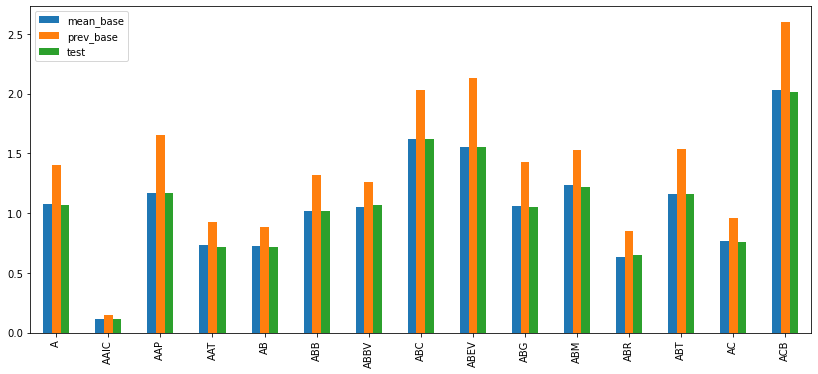

In [138]:
res_df.plot.bar(figsize=(14,6));

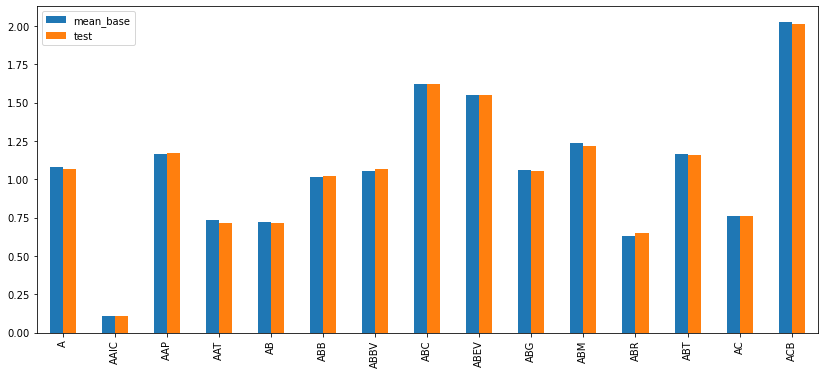

In [140]:
res_df[['mean_base', 'test']].plot.bar(figsize=(14,6));

## Looking Further Ahead

Here I try making predictions over longer time periods.   
Each day I go further into the future I add the previous prediction to the end of X and slice off the first value in each x in X to make the next prediction

In [156]:
future = [1, 2, 4, 7, 12, 17, 22, 27, 32, 37]
resf = {}
for sym in syms:
    X, y, xb = gen_test(sym)
    X = X[:80]
    resf[sym +'_lstm'] = {}
    resf[sym +'_mean_base'] = {}
    resf[sym +'_prev_base'] = {}
    
    model = load_model(f'models/comp_{sym}.h5')
    
    e=1
    Xd = X
    yd = model.predict(Xd)
    yd = np.array(yd).reshape(-1,1, 1)
    for f in future:
        for d in range(e, f):
            Xd = np.hstack((Xd, yd))[:,1:,:]
            yd = model.predict(Xd)
            yd = np.array(yd).reshape(-1,1, 1)
        e = f
        resf[sym +'_lstm'][f] = MSE(y[f-1:f+79], yd.reshape((-1,)), squared=False)
    
    
        mean = [np.mean(x) for x in X[:80]]
        resf[sym + '_mean_base'][f] = MSE(y[f-1:f+79], mean, squared=False)
        resf[sym + '_prev_base'][f] = MSE(y[f-1:f+79], xb[:80], squared=False)
    
resf = pd.DataFrame(resf)
resf    
    
    

,A_lstm,A_mean_base,A_prev_base,AAIC_lstm,AAIC_mean_base,AAIC_prev_base,AAP_lstm,AAP_mean_base,AAP_prev_base,AAT_lstm,...,ABR_prev_base,ABT_lstm,ABT_mean_base,ABT_prev_base,AC_lstm,AC_mean_base,AC_prev_base,ACB_lstm,ACB_mean_base,ACB_prev_base
1,1.124875,1.140509,1.555066,0.108205,0.108674,0.139871,1.120289,1.087063,1.563254,0.647709,...,0.865616,0.979041,0.988492,1.413554,0.696581,0.698118,0.838873,1.241225,1.253254,1.504072
2,0.689628,0.709965,1.323929,0.108222,0.108897,0.157250,1.119790,1.085775,1.517622,0.659296,...,0.983920,0.965812,0.971488,1.490421,0.694623,0.697543,0.984245,1.241693,1.259410,1.797367
4,0.692319,0.708413,1.432783,0.108158,0.107997,0.158062,1.118985,1.089952,1.573868,0.661752,...,0.872041,0.973899,0.975527,1.307994,0.686790,0.687279,1.088513,1.245716,1.255876,1.609955
7,0.675494,0.684303,1.391703,0.106461,0.106129,0.146291,1.111856,1.088544,1.504734,0.664634,...,0.889455,0.983449,0.977544,1.416725,0.677916,0.679476,0.904570,1.240601,1.243952,1.736497
12,0.653510,0.659650,1.348110,0.104887,0.104294,0.160423,1.139754,1.116123,1.607606,0.676688,...,0.829280,0.960747,0.947036,1.373900,0.687705,0.688348,1.030390,1.531880,1.549360,1.919077
17,0.651786,0.656996,1.322346,0.103406,0.103338,0.155500,1.143524,1.126899,1.635022,0.679814,...,0.988066,1.058234,1.039966,1.412925,0.812642,0.815093,1.123824,1.603998,1.612751,2.088452
22,0.653682,0.660880,1.232998,0.105297,0.104821,0.147893,1.141744,1.137560,1.594233,0.694332,...,0.995278,1.119837,1.114330,1.404300,0.821583,0.824608,1.154707,1.635424,1.658489,1.970470
27,0.704122,0.718232,1.371581,0.092426,0.091871,0.153507,1.189266,1.190577,1.577038,0.765982,...,0.902830,1.201968,1.203403,1.615322,0.852446,0.854528,1.062236,1.683623,1.689931,2.165853
32,0.701555,0.711859,1.413907,0.093357,0.091592,0.143366,1.256810,1.257325,1.718962,0.749066,...,0.845115,1.255766,1.255604,1.653932,0.825520,0.826460,0.990445,1.988958,2.002455,2.346717
37,0.726086,0.742537,1.415714,0.096708,0.095858,0.142423,1.254779,1.255694,1.731467,0.765209,...,0.908270,1.255604,1.263594,1.507124,0.818115,0.822056,1.119722,2.228273,2.239527,2.628499


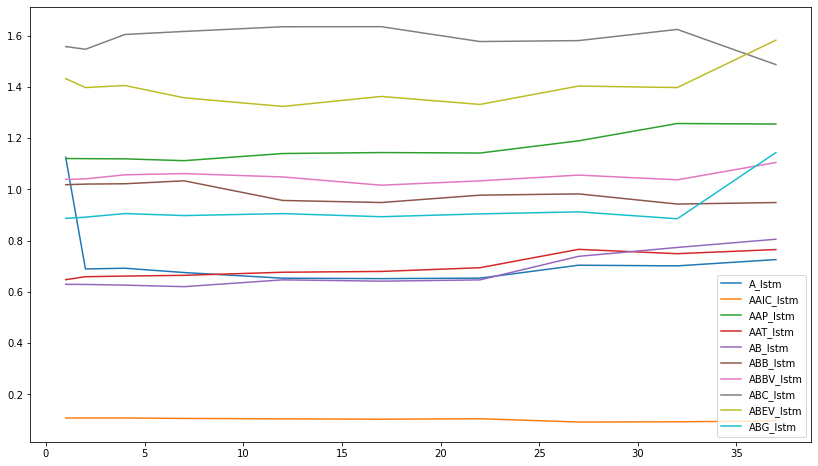

In [157]:
lstms = [col for col in resf.columns if 'lstm' in col]
means = [col for col in resf.columns if 'mean' in col]
resf[lstms[:10]].plot(figsize=(14,8));

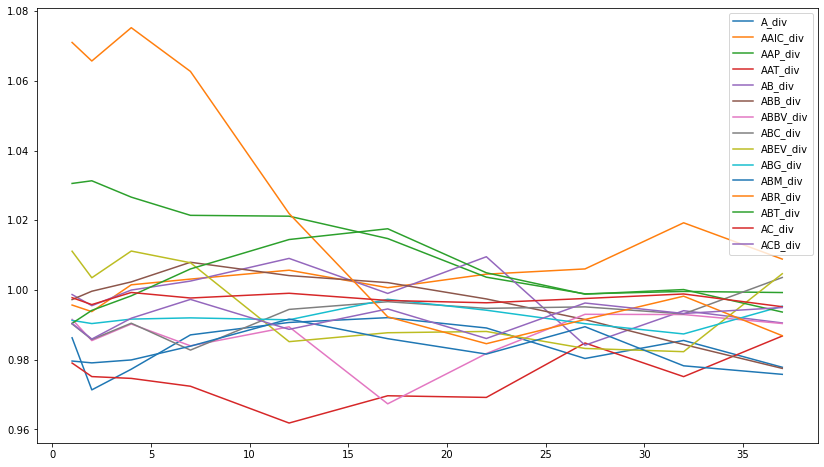

In [167]:
for sym in syms:
    resf[sym + '_div'] = resf[sym + '_lstm'] / resf[sym + '_mean_base']
divs = [col for col in resf.columns if 'div' in col]
resf[divs].plot(figsize=(14,8));
# lower: better; lower than 1: better than mean

In [123]:
#dividing the RMSEs by the std, however this can reward high std as shown in 'A'
std = {}
for sym in syms:
    X, y, xb = gen_test(sym)
    std[sym] = np.std(y)

resfsc = {}
for i, col in enumerate(resf.columns):
    resfsc[col] = resf[col]/std[syms[i//3]]
resfsc = pd.DataFrame(resfsc)    
resfsc


,A_lstm,A_mean,A_prev_base,AAIC_lstm,AAIC_mean,AAIC_prev_base,AAP_lstm,AAP_mean,AAP_prev_base,AAT_lstm,...,ABR_prev_base,ABT_lstm,ABT_mean,ABT_prev_base,AC_lstm,AC_mean,AC_prev_base,ACB_lstm,ACB_mean,ACB_prev_base
1,1.057628,1.072328,1.462102,0.993542,0.997848,1.284300,0.971501,0.942687,1.355634,0.900547,...,1.386058,0.847091,0.855268,1.223043,0.918147,0.920174,1.105700,0.616726,0.622703,0.747326
2,0.648401,0.667523,1.244782,0.993695,0.999899,1.443873,0.971068,0.941570,1.316063,0.916659,...,1.575492,0.835645,0.840556,1.289550,0.915567,0.919415,1.297311,0.616959,0.625762,0.893056
4,0.650931,0.666063,1.347129,0.993116,0.991637,1.451329,0.970369,0.945193,1.364838,0.920073,...,1.396348,0.842642,0.844051,1.131710,0.905243,0.905887,1.434744,0.618957,0.624006,0.799936
7,0.635112,0.643395,1.308505,0.977530,0.974481,1.343248,0.964188,0.943972,1.304886,0.924080,...,1.424231,0.850906,0.845796,1.225787,0.893546,0.895602,1.192293,0.616416,0.618081,0.862811
12,0.614442,0.620215,1.267518,0.963076,0.957635,1.473009,0.988381,0.967888,1.394095,0.940839,...,1.327876,0.831263,0.819400,1.188734,0.906448,0.907296,1.358135,0.761144,0.769829,0.953530
17,0.612821,0.617720,1.243294,0.949478,0.948853,1.427807,0.991650,0.977233,1.417870,0.945186,...,1.582131,0.915611,0.899805,1.222499,1.071126,1.074356,1.481288,0.796977,0.801326,1.037687
22,0.614604,0.621371,1.159287,0.966843,0.962469,1.357963,0.990106,0.986478,1.382499,0.965371,...,1.593679,0.968912,0.964146,1.215036,1.082911,1.086898,1.521993,0.812591,0.824052,0.979065
27,0.662029,0.675295,1.289586,0.848663,0.843563,1.409511,1.031317,1.032453,1.367587,1.064990,...,1.445648,1.039973,1.041215,1.397618,1.123590,1.126335,1.400110,0.836540,0.839674,1.076145
32,0.659615,0.669303,1.329382,0.857212,0.840999,1.316390,1.089890,1.090337,1.490662,1.041471,...,1.353232,1.086521,1.086381,1.431025,1.088099,1.089338,1.305483,0.988251,0.994958,1.166011
37,0.682679,0.698147,1.331081,0.887980,0.880175,1.307736,1.088129,1.088922,1.501507,1.063915,...,1.454358,1.086380,1.093293,1.304002,1.078339,1.083534,1.475880,1.107160,1.112751,1.306020


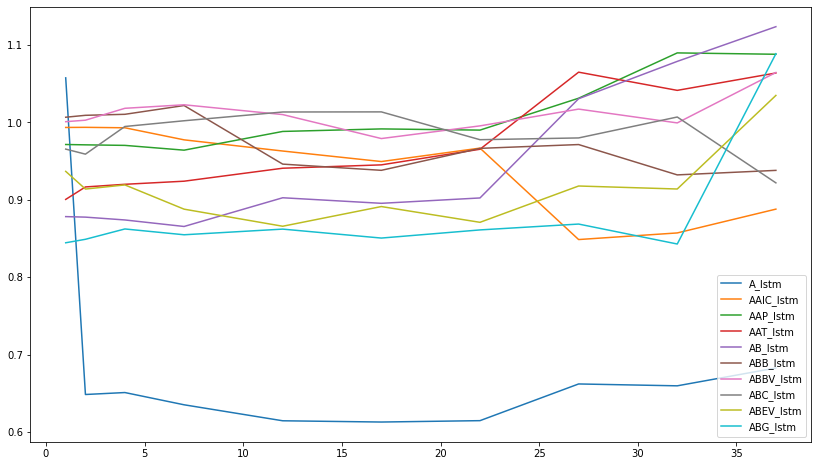

In [169]:
resfsc[lstms[:10]].plot(figsize=(14,8));

In [130]:
#r_squared
future = [1, 2, 4, 7, 12, 17, 22, 27, 32, 37]
resfr2 = {}
for sym in syms:
    X, y, xb = gen_test(sym)
    X = X[:80]
    resfr2[sym +'_lstm'] = {}
    resfr2[sym +'_mean_base'] = {}
    resfr2[sym +'_prev_base'] = {}
    
    model = load_model(f'models/comp_{sym}.h5')
    
    for f in future:
        Xd = X
        yd = model.predict(Xd)
        yd = np.array(yd).reshape(-1,1, 1)
        for d in range(f):
            yd = model.predict(Xd)
            yd = np.array(yd).reshape(-1,1, 1)
            Xd = np.hstack((Xd, yd))[:,1:,:]
        
        resfr2[sym +'_lstm'][f] = r2_score(y[f-1:f+79], yd.reshape((-1,)))
    
    
        mean = [np.mean(x) for x in X[:80]]
        resfr2[sym + '_mean_base'][f] = r2_score(y[f-1:f+79], mean)
        resfr2[sym + '_prev_base'][f] = r2_score(y[f-1:f+79], xb[:80])

resfr2 = pd.DataFrame(resfr2)
resfr2    
    
    

,A_lstm,A_mean_base,A_prev_base,AAIC_lstm,AAIC_mean_base,AAIC_prev_base,AAP_lstm,AAP_mean_base,AAP_prev_base,AAT_lstm,...,ABR_prev_base,ABT_lstm,ABT_mean_base,ABT_prev_base,AC_lstm,AC_mean_base,AC_prev_base,ACB_lstm,ACB_mean_base,ACB_prev_base
1,0.003341,-0.024556,-0.904741,-0.036197,-0.045199,-0.731423,-0.098514,-0.034318,-1.138967,-0.001989,...,-0.971478,-0.001888,-0.021325,-1.088540,-0.007018,-0.011469,-0.460451,-0.006641,-0.026248,-0.478124
2,-0.006209,-0.066429,-2.708403,-0.035869,-0.048842,-1.187037,-0.101344,-0.035450,-1.022912,-0.007825,...,-1.523559,-0.006049,-0.017908,-1.395805,-0.006932,-0.015414,-1.021660,-0.006294,-0.035215,-1.108483
4,-0.006841,-0.054196,-3.312304,-0.034766,-0.031685,-1.209906,-0.101762,-0.045332,-1.179596,-0.015657,...,-1.244857,-0.008725,-0.012099,-0.819518,-0.007138,-0.008571,-1.529922,-0.008619,-0.025140,-0.684678
7,-0.005622,-0.032023,-3.268598,-0.035530,-0.029079,-0.955304,-0.095511,-0.050055,-1.006500,-0.010627,...,-1.303779,-0.016350,-0.004182,-1.109164,-0.005970,-0.010604,-0.791088,-0.007876,-0.013328,-0.974653
12,-0.028876,-0.048299,-3.378331,-0.026668,-0.015100,-1.401705,-0.075537,-0.031400,-1.139744,0.018879,...,-0.715873,-0.018735,0.010135,-1.083306,-0.006226,-0.008110,-1.258891,-0.014976,-0.038272,-0.592909
17,-0.014279,-0.030559,-3.174819,-0.031339,-0.029982,-1.332226,-0.056699,-0.026197,-1.160269,0.007955,...,-1.343885,-0.037429,-0.001920,-0.849409,-0.002295,-0.008348,-0.916874,-0.007925,-0.018954,-0.708713
22,-0.003491,-0.025711,-2.570299,-0.038824,-0.029446,-1.049300,-0.039582,-0.031976,-1.026865,0.000927,...,-1.401293,-0.024815,-0.014760,-0.611594,-0.007447,-0.014879,-0.990044,-0.012242,-0.040996,-0.469478
27,-0.002012,-0.042573,-2.802065,-0.039307,-0.026853,-1.866885,-0.019279,-0.021528,-0.792336,-0.018523,...,-0.855281,-0.012262,-0.014680,-0.828208,-0.001206,-0.006103,-0.554646,-0.008866,-0.016440,-0.669560
32,-0.002376,-0.032035,-3.071447,-0.062153,-0.022353,-1.504835,-0.022855,-0.023693,-0.913406,0.009006,...,-0.609948,-0.010178,-0.009918,-0.752331,0.000608,-0.001669,-0.438605,-0.009762,-0.023514,-0.405689
37,0.000030,-0.045796,-2.801560,-0.066495,-0.047829,-1.313090,-0.021438,-0.022928,-0.944938,-0.006161,...,-0.955754,-0.006881,-0.019736,-0.450678,0.001542,-0.008101,-0.870345,-0.001455,-0.011597,-0.393512


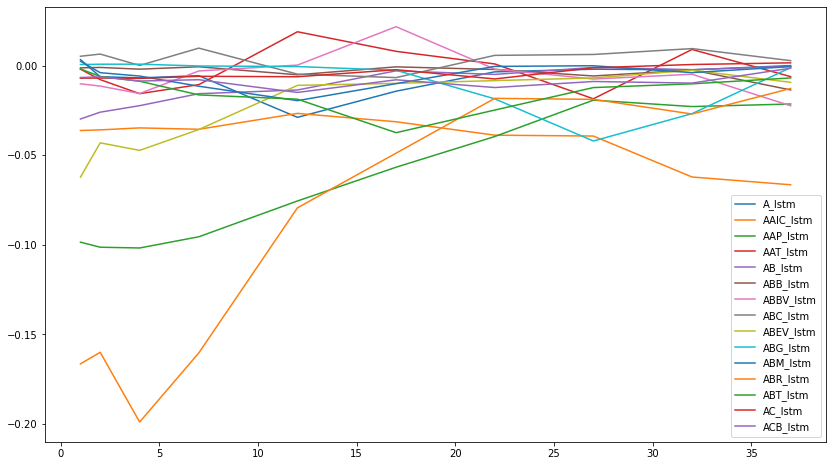

In [132]:
resfr2[lstms].plot(figsize=(14,8));

In [116]:
#concordant pairs
future = [1, 2, 4, 7, 12, 17, 22, 27, 32, 37]
resf = {}
for sym in syms:
    X, y, xb = gen_test(sym)
    X = X[:80]
#     resf[sym] = {}
    resf[sym +'_lstm'] = {}
    resf[sym +'_mean'] = {}
    resf[sym +'_prev_base'] = {}
    
    model = load_model(f'models/comp_{sym}.h5')
    
#     qwey = {}
#     qwexb = {}
    
    for f in future:
        Xd = X
        yd = model.predict(Xd)
        yd = np.array(yd).reshape(-1,1, 1)
        for d in range(f):
            Xd = np.hstack((Xd, yd))[:,1:,:]
            yd = model.predict(Xd)
            yd = np.array(yd).reshape(-1,1, 1)
        
        resf[sym +'_lstm'][f] = sum(np.sign(y[f-1:f+79])*np.sign(yd.reshape((-1,))))
        mean = [np.mean(x) for x in X[:80]]
        resf[sym + '_mean'][f] = sum(np.sign(y[f-1:f+79])*np.sign(mean))
        resf[sym + '_prev_base'][f] = sum(np.sign(y[f-1:f+79])*np.sign(xb[:80]))
    
    
#     resf[sym]['mean_base'] = MSE(y[:90], mean, squared=False)
#     resf[sym]['prev_base'] = MSE(y[:90], xb[:90], squared=False)
#     resf[sym]['test'] = MSE(y[:90], yp, squared=False)
    
    break
    
resf = pd.DataFrame(resf)
resf    
    
    

,A_lstm,A_mean,A_prev_base
1,6.0,-8.0,8.0
2,6.0,-6.0,2.0
4,2.0,-6.0,6.0
7,-2.0,-2.0,-18.0
12,-6.0,0.0,0.0
17,4.0,-6.0,6.0
22,-4.0,-4.0,12.0
27,-6.0,-2.0,-2.0
32,-6.0,-2.0,6.0
37,-6.0,-2.0,-2.0
